# Spatial averaged vector autoregressive model (SAVAR) 

SAVAR is a spatio-temporal model where some regions, the so-called modes, affect each other according to some underlying causal model. Modes are regions with covariant noise. We name components to the weighted average of the modes that affect the value of other modes in future time-steps. 

The model is given by the following expression: 

$$
	y_t^\ell:= \sum_{j=1}^{N}u^{\ell j}\sum_{i=1}^{N}\sum_{\tau=1}^{\tau_{max}}\phi^{ji}(\tau)\sum_{\ell}^{L}w^{i \ell} y_{t-\tau}^\ell+\epsilon^\ell_t
$$

where $y_t^\ell$ is the value of the random variable $y$ at time $t$ at location $\ell$, $u^{\ell j}$ is the coefficient that relates how the $j$-th component contributes to the value of $y^\ell_t$, $\phi^{ji}(\tau)$ is the contribution to the $i$-th component to the $j$-th component at time lag $\tau$, $w^{i\ell}$ is the coefficient that relates how $y^\ell$ contributes to the $i$-th and $\epsilon_t^\ell$ stands for a a noise term where $\epsilon_t^\ell \sim \mathcal{N}(\mu, \Sigma)$ and $\Sigma \in \mathbb{R}^{L\times L}$ is the correlation matrix.

the matrix form is given by

$$
	\mathbf{y}_t = W^+\sum_{\tau=1}^{\tau_{max}}\Phi(\tau) W \mathbf{y}_{t-\tau}+\mathbf{\epsilon}_t
$$

where $\mathbf y^T_t = (y^1_t, \dots, y^L_t)$, $u^{\ell j} \in W^+$, $\phi^{i j}(\tau)\in \Phi(\tau)$, $w^{i\ell} \in W$ and $\epsilon_t^\ell \in \mathbf \epsilon_t$. The matrix $W^+$ is the Moore-Penrose pseudoinvers of $W$. This is, $WW^+W=W$.


In [1]:
import spatial_models as models
import matplotlib.pyplot as plt
from functions import create_random_mode, check_stability
from c_functions import deseason_data, standardize_data, compare_modes

import numpy as np

In [2]:
# Some definitions

nx = 30  
ny = 90 # Each component is 30x30
T = 5000 # Time 

In [3]:
# Setup spatial weights of underlying processes

N = 3 # Three components

noise_weights = np.zeros((N, nx, ny))
modes_weights = np.zeros((N, nx, ny))

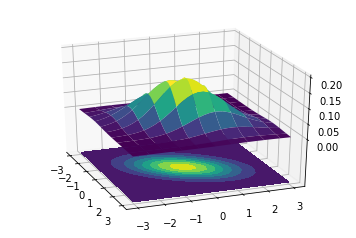

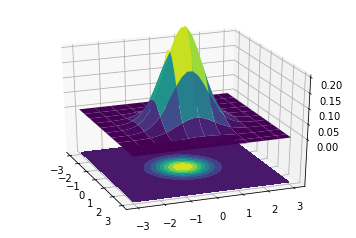

In [4]:
# There is a function to create random  modes 
_ = create_random_mode((30, 30), plot=True, random = True)

# If no random X is independent of y
_ = create_random_mode((30, 30), plot=True, random = False)

In [5]:
# We can create the modes with it.
noise_weights = np.zeros((N, nx, ny))
noise_weights[0, :, :30] = create_random_mode((30, 30), random = False)
noise_weights[1, :, 30:60] = create_random_mode((30, 30), random = False)
noise_weights[2, :, 60:] = create_random_mode((30, 30), random = False)

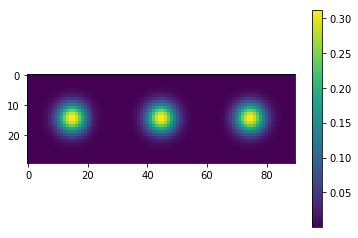

In [6]:
# How the modes look like
plt.imshow(noise_weights.sum(axis=0))
plt.colorbar()

With them, we define $\Sigma$. But is it also necessary to define $W$. This is, how we average this mode to influence other modes, according to an underlying VAR(p) process. This process is determined by $\Phi$ which we introduce in the same way as Tigramite.

In [7]:
# We can use the same
modes_weights = noise_weights

# Or just assume that the mean value of the whole regions is used.
#noise_weights = np.zeros((N, nx, ny))
#noise_weights[0, :, :30] = 0.01
#noise_weights[1, :, 30:60] = 0.01
#noise_weights[2, :, 60:] = 0.01

# And the causal model
links_coeffs = {
    0: [((0, 1), 0.5), ((2, 2), -0.4)],
    1: [((1, 1), 0.5), ((0, 1), 0.4)],
    2: [((2, 1), 0.5), ((1, 1), 0.4)]
}

# One good thing of SAVAR is that if the underlying process is stable and stationary, then SAVAR is also both. 
# Independently of W. This is, we only need to check for stationarity of \PHI and not of W^+\PHI W
check_stability(links_coeffs)

Spatial covariance is a key parameter that tells you how strong the noise covarie in the regions of the modes variability. If They covary to much, they will be uncoupled with W, and if they covary to few, they will be mixed. 

If the option `covariance_noise_method="geometric_mean"`(by default), then $\Sigma$ is computed from $W$ as follows

$$
(\Sigma)_{jk} = \frac{1}{N}\sum^{N}_{i=1}\sqrt{w^{ij}w^{ik}} \; for j\ne k
$$

for $j = k$ the parameter `variance_noise` is used. 

Let's see some examples:

In [8]:
spatial_covariance = 0.1

savar = models.savarModel(
    links_coeffs=links_coeffs,
    modes_weights=modes_weights, 
    nx=nx,
    ny=ny,
    T=5000,
    spatial_covariance=spatial_covariance,
    noise_weights=noise_weights,
    transient = 200, 
    n_variables = N,
    verbose = False
)
savar.create_linear_savar_data()


0.3115694608260862
0.3115694608260862
0.3115694608260862
We are inside compute linear savar


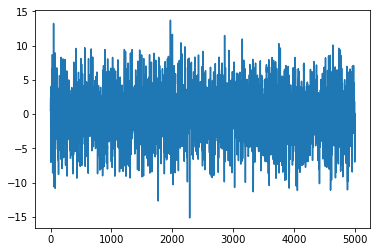

In [9]:
# We can check the time series of one mode
plt.plot(savar.network_data[:, 1])

In [10]:
# Or check the dimension of the entire field
savar.data_field.shape

(5000, 2700)

In [11]:
# We also implement our own version of PCA-VariMax
from c_dim_methods import get_varimax_loadings_standard as varimax
modes = varimax(savar.data_field)

Get Varimax components
	 Get SVD
	 User-selected number of components: 60
	 Explaining 0.06 of variance
	 Varimax rotation
	 Further metrics


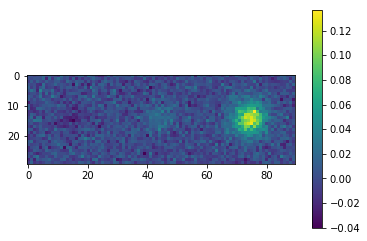

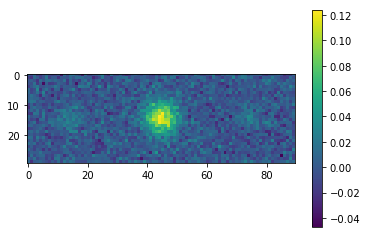

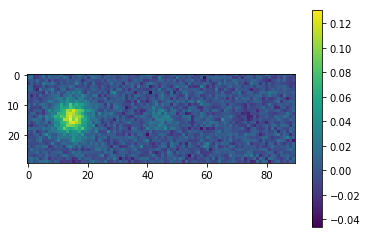

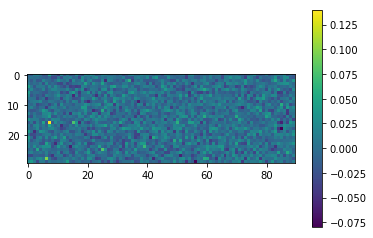

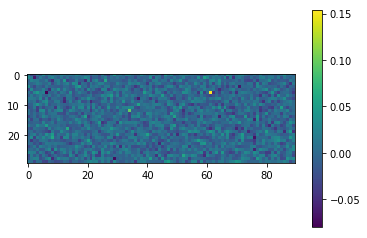

In [12]:
# Let's plot some of them.
for i in range(5):
    plt.imshow(modes['weights'][:, i].reshape(30, 90))
    plt.colorbar()
    plt.show()


We can observe that the components are mixted. This is because their relation is linear and they are autocorrelated. So we can observe a linear relation between them (and PCA mix them). One easy way to overcome this is by assuming that autocorrelation is 0.

In [13]:
links_coeffs = {
    0: [((0, 1), 0), ((2, 2), -0.8)],
    1: [((1, 1), 0), ((0, 1), 0.8)],
    2: [((2, 1), 0), ((1, 1), 0.8)]
}

0.3115694608260862
0.3115694608260862
0.3115694608260862
We are inside compute linear savar
Get Varimax components
	 Get SVD
	 User-selected number of components: 60
	 Explaining 0.07 of variance
	 Varimax rotation
	 Further metrics


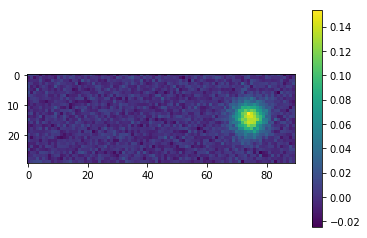

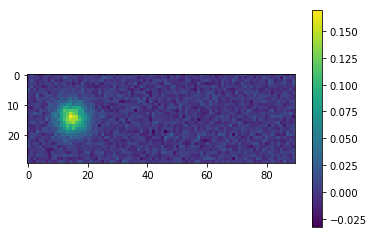

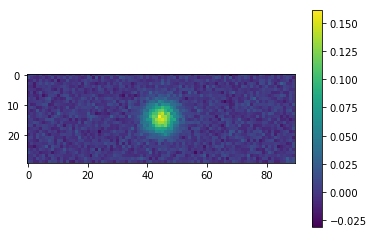

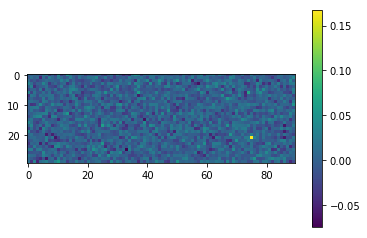

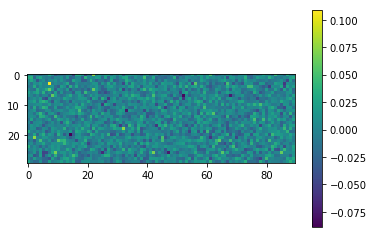

In [14]:
spatial_covariance = 0.1
savar = models.savarModel(
    links_coeffs=links_coeffs,
    modes_weights=modes_weights, 
    ny=ny,
    nx=nx,
    T=5000,
    spatial_covariance=spatial_covariance,
    noise_weights=noise_weights,
    transient = 200, 
    n_variables = N,
    verbose = False
)
savar.create_linear_savar_data()
modes = varimax(savar.data_field)
for i in range(5):
    plt.imshow(modes['weights'][:, i].reshape(30, 90))
    plt.colorbar()
    plt.show()

Other way to avoid mixing is by setting larger lags. 

In [15]:
links_coeffs = {
    0: [((0, 1), 0.5), ((2, 6), -0.4)],
    1: [((1, 1), 0.5), ((0, 5), 0.4)],
    2: [((2, 1), 0.5), ((1, 5), 0.4)]
}

0.3115694608260862
0.3115694608260862
0.3115694608260862
We are inside compute linear savar
Get Varimax components
	 Get SVD
	 User-selected number of components: 60
	 Explaining 0.06 of variance
	 Varimax rotation
	 Further metrics


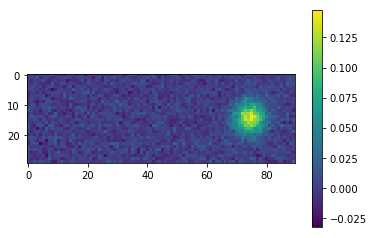

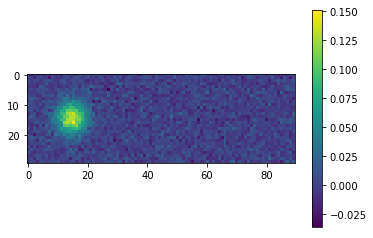

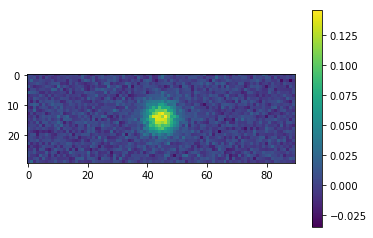

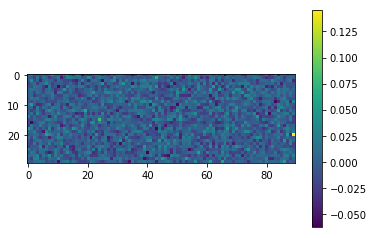

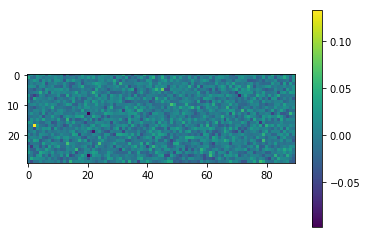

In [16]:
savar = models.savarModel(
    links_coeffs=links_coeffs,
    modes_weights=modes_weights, 
    ny=ny,
    nx=nx,
    T=5000,
    spatial_covariance=spatial_covariance,
    noise_weights=noise_weights,
    transient = 200, 
    n_variables = N,
    verbose = False
)
savar.create_linear_savar_data()
modes = varimax(savar.data_field)
for i in range(5):
    plt.imshow(modes['weights'][:, i].reshape(30, 90))
    plt.colorbar()
    plt.show()

As said, raising the spatial covariance helps.

0.3115694608260862
0.3115694608260862
0.3115694608260862
We are inside compute linear savar
Get Varimax components
	 Get SVD
	 User-selected number of components: 60
	 Explaining 0.07 of variance
	 Varimax rotation
	 Further metrics


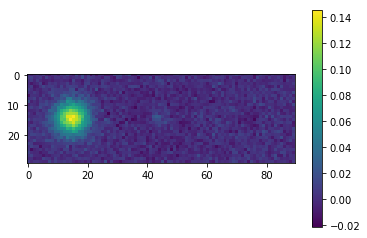

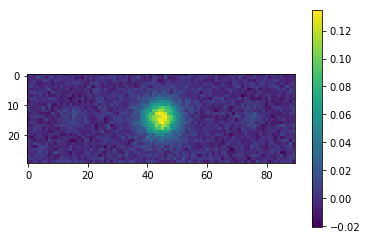

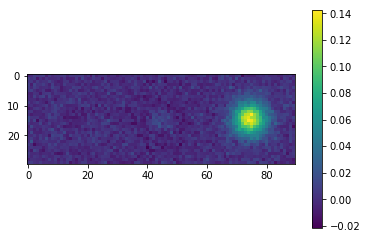

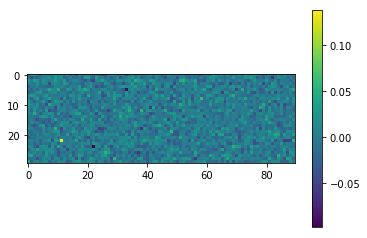

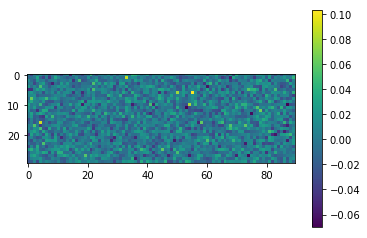

In [17]:
links_coeffs = {
    0: [((0, 1), 0.5), ((2, 2), -0.4)],
    1: [((1, 1), 0.5), ((0, 1), 0.4)],
    2: [((2, 1), 0.5), ((1, 1), 0.4)]
}

spatial_covariance=0.5

savar = models.savarModel(
    links_coeffs=links_coeffs,
    modes_weights=modes_weights, 
    ny=ny,
    nx=nx,
    T=5000,
    spatial_covariance=spatial_covariance,
    noise_weights=noise_weights,
    transient = 200, 
    n_variables = N,
    verbose = False
)
savar.create_linear_savar_data()
modes = varimax(savar.data_field)
for i in range(5):
    plt.imshow(modes['weights'][:, i].reshape(30, 90))
    plt.colorbar()
    plt.show()

But too much also uncouples $w$ and $\Sigma$

2700 2700
0.3115694608260862
0.3115694608260862
0.3115694608260862
[1.61595104e-09 2.94235484e-09 5.13300166e-09 ... 5.13300166e-09
 2.94235484e-09 1.61595104e-09]
We are inside compute linear savar
Get Varimax components
	 Get SVD
	 User-selected number of components: 60
	 Explaining 0.12 of variance
	 Varimax rotation
	 Further metrics


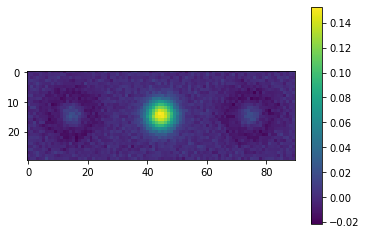

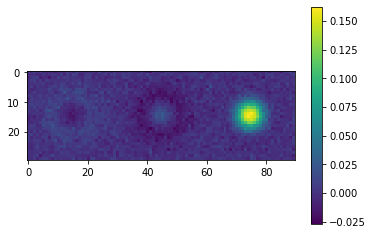

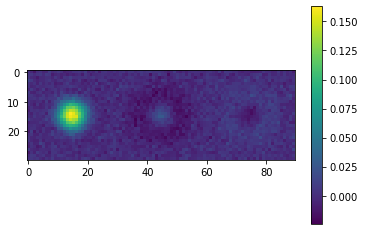

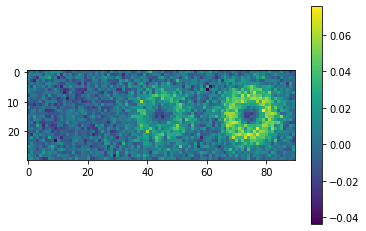

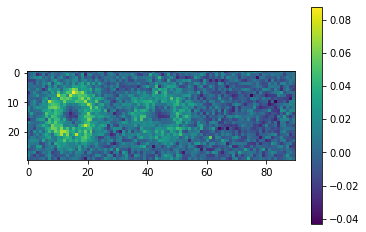

In [83]:
links_coeffs = {
    0: [((0, 1), 0.5), ((2, 2), -0.4)],
    1: [((1, 1), 0.5), ((0, 1), 0.4)],
    2: [((2, 1), 0.5), ((1, 1), 0.4)]
}

spatial_covariance=4

savar = models.savarModel(
    links_coeffs=links_coeffs,
    modes_weights=modes_weights, 
    ny=ny,
    nx=nx,
    T=5000,
    spatial_covariance=spatial_covariance,
    noise_weights=noise_weights,
    transient = 200, 
    n_variables = N,
    verbose = False
)
savar.create_linear_savar_data()
modes = varimax(savar.data_field)
for i in range(5):
    plt.imshow(modes['weights'][:, i].reshape(30, 90))
    plt.colorbar()
    plt.show()

SAVAR also allows for the inclusion of non-linearities. Let's assume that all the interactinons, among different components are non-linear

In [84]:
links_coeffs = {
    0: [((0, 1), 0.3, "linear"),
        ((0, 1), 0.0, "f2"),
        ((2, 2), -0.7, "linear"),
        ((2, 2), -0.0, "f2")],  
    1: [((1, 1), 0.3, "linear"), 
        ((1, 1), 0.0, "f2"),
        ((0, 1), 0.7, "linear"),
        ((0, 1), 0.0, "f2")],
    2: [((2, 1), 0.3, "linear"),
        ((2, 1), 0.0, "f2"),
        ((1, 1), 0.7, "linear"),
        ((1, 1), 0.0, "f2")]
}

In [85]:


savar = models.savarModel(
    links_coeffs=links_coeffs,
    modes_weights=modes_weights, 
    ny=ny,
    nx=nx,
    T=5000,
    spatial_covariance=0.1,
    noise_weights=noise_weights,
    transient = 200, 
    n_variables = N,
    lineartiy="non-linear",
    verbose = True
)

In [86]:
savar.create_nonlinear_savar_data()

Start...
2700 2700
0.3115694608260862
0.3115694608260862
0.3115694608260862
[1.61595104e-09 2.94235484e-09 5.13300166e-09 ... 5.13300166e-09
 2.94235484e-09 1.61595104e-09]
Compute values in time...
We are inside compute nonlinear savar
Done...


In [87]:
savar.data_field

array([[ 0.23309116, -0.347245  , -0.49687486, ...,  0.55212438,
         1.19177994,  1.08106312],
       [-0.59336828,  1.64159916, -0.68453491, ..., -0.31372273,
         0.81161109,  1.04350179],
       [-1.58617323, -0.04666725,  1.22980593, ..., -0.09107022,
         1.43250391,  0.45695743],
       ...,
       [-2.08479462,  0.67197236,  1.27027801, ...,  0.68581424,
         0.05386448, -1.74458656],
       [-0.09593452,  1.38693339,  0.68900041, ...,  0.71663045,
        -1.20331177, -1.04197135],
       [ 0.50986102,  0.48783299, -0.34753797, ...,  1.00701946,
        -0.45332302,  0.06866374]])

Get Varimax components
	 Get SVD
	 User-selected number of components: 60
	 Explaining 0.16 of variance
	 Varimax rotation
	 Further metrics


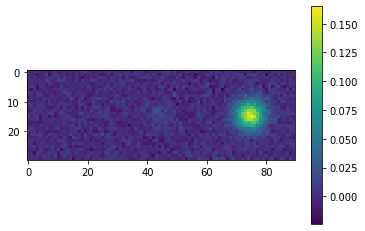

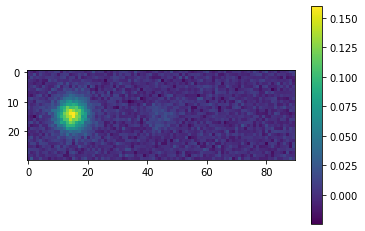

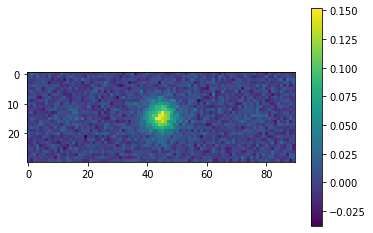

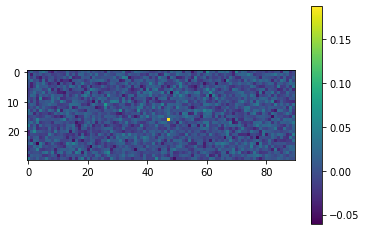

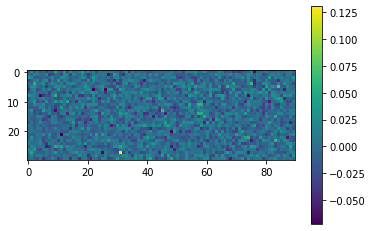

In [88]:
from c_dim_methods import get_varimax_loadings_standard as varimax
modes = varimax(savar.data_field)
for i in range(5):
    plt.imshow(modes['weights'][:, i].reshape(30, 90))
    plt.colorbar()
    plt.show()